# Importing required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

2023-08-13 22:57:36.546088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 22:57:36.588313: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 22:57:36.588908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 22:57:37.425887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Preprocessing

In [2]:
# Reading csv file
df = pd.read_csv('training_data/letras_musicas.csv')
df.head()

,Título,Letra
0,'03 Bonnie & Clyde (feat. Jay-Z),"\nUhh, uhh, uhh\nYou ready, B?\nLet's go get ..."
1,1+1,\nIf I ain't got nothing\nI got you\nIf I ain...
2,6 Inch (feat. The Weeknd),\n[Beyoncé]\nSix inch heels\nShe walked in th...
3,632-5792,\n(Hello) hello\nHow are you (oh)\nI just got...
4,7/11,"\nShoulders sideways, smack it, smack it in t..."


In [13]:
df = df[~df.index.isin([375,412])] # drop letras em português
df.reset_index(inplace=True)


In [14]:
df = df[['Letra']]

# Função para quebrar o texto e adicionar novas linhas ao DataFrame
def quebrar_e_adicionar_linhas(row):
    textos_quebrados = row['Letra'].splitlines()
    return pd.DataFrame({'Letra': textos_quebrados})

# Aplicar a função para cada linha do DataFrame e combinar os resultados
novo_df = pd.concat([quebrar_e_adicionar_linhas(row) for _, row in df.iterrows()], ignore_index=True)

In [15]:
novo_df

,Letra
0,
1,"Uhh, uhh, uhh"
2,"You ready, B?"
3,Let's go get 'em
4,Look for me!
...,...
25732,"The people, the people"
25733,"If you ask me, baby"
25734,"I'll do anything you say you, boy"
25735,I’m talking to you


In [16]:
novo_df.columns =  ['lyric']

In [18]:
# corpus will contain data that'll be converted to number sequences. 
corpus = novo_df['lyric'].tolist()
corpus[0:6]

[' ',
 'Uhh, uhh, uhh',
 'You ready, B?',
 "Let's go get 'em",
 'Look for me!',
 "Young, B, cruisin' down the Westside Highway"]

In [19]:
# tokenizer will contain key value index to every word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# will be used during prediction
reverse_word_index = dict(map(reversed, tokenizer.word_index.items()))

print('Total Words - ',total_words)
print("key of word 'around' is ",tokenizer.word_index['around'])
print("key of id '117' is ",reverse_word_index[117])

Total Words -  7811
key of word 'around' is  109
key of id '117' is  more


In [20]:
# Converting input to a sequence of number
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label where label is just the last value of every input_sequence
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

print(xs[10])
print(np.argmax(ys[100]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 313 271]
159


## Creating LSTM Model and fitting data on it!

In [21]:

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
# model.add(Bidirectional(LSTM(256,return_sequences= True)))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print (model.summary())
#history = model.fit(xs, ys, epochs=100, verbose=1)
history = model.fit(xs, ys, epochs=50, verbose=1)

2023-08-13 23:02:10.025920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-08-13 23:02:10.025992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: kunumi-Inspiron-5590
2023-08-13 23:02:10.026000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: kunumi-Inspiron-5590
2023-08-13 23:02:10.026115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.199.2
2023-08-13 23:02:10.026134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.199.2
2023-08-13 23:02:10.026139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 470.199.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           781100    
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 7811)              2351111   
                                                                 
Total params: 3433411 (13.10 MB)
Trainable params: 3433411 (13.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50


2023-08-13 23:02:12.893473: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4263524996 exceeds 10% of free system memory.


4265/4265 [==============================] - 454s 106ms/step - loss: 5.7298 - accuracy: 0.0971
Epoch 2/50
4265/4265 [==============================] - 455s 107ms/step - loss: 4.5134 - accuracy: 0.2221
Epoch 3/50
4265/4265 [==============================] - 455s 107ms/step - loss: 3.8012 - accuracy: 0.3127
Epoch 4/50
4265/4265 [==============================] - 454s 106ms/step - loss: 3.2924 - accuracy: 0.3812
Epoch 5/50
4265/4265 [==============================] - 454s 106ms/step - loss: 2.9047 - accuracy: 0.4334
Epoch 6/50
4265/4265 [==============================] - 453s 106ms/step - loss: 2.6048 - accuracy: 0.4779
Epoch 7/50
4265/4265 [==============================] - 455s 107ms/step - loss: 2.3631 - accuracy: 0.5161
Epoch 8/50
4265/4265 [==============================] - 454s 106ms/step - loss: 2.1660 - accuracy: 0.5484
Epoch 9/50
4265/4265 [==============================] - 454s 106ms/step - loss: 2.0045 - accuracy: 0.5769
Epoch 10/50
4265/4265 [==============================] - 

## Plotting accuracy over epoch

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

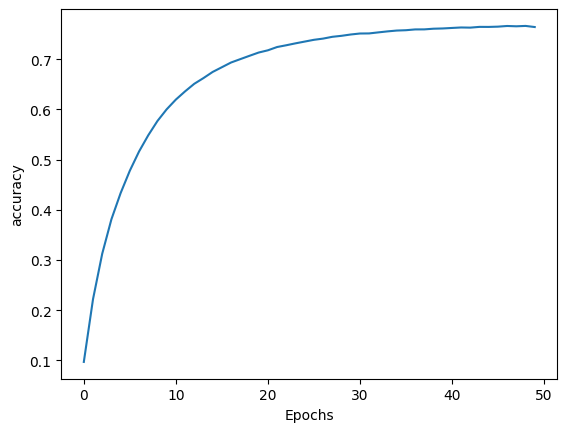

In [23]:
plot_graphs(history, 'accuracy')

## Finally Saving Tokenizer and Trained Model !

In [24]:
import pickle

with open('model_files/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('model_files/lyrics_model.h5')

/home/kunumi/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
